In [1]:
!pip install --upgrade scikit-learn

In [2]:
# Keras and TensorFlow for DNN
!pip install tensorflow

In [3]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install LogisticRegression

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement LogisticRegression (from versions: none)
ERROR: No matching distribution found for LogisticRegression


In [8]:
pip install imblearn

In [9]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install SVC

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install GaussianNB

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement GaussianNB (from versions: none)
ERROR: No matching distribution found for GaussianNB


In [13]:
pip install AdaBoostClassifier

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement AdaBoostClassifier (from versions: none)
ERROR: No matching distribution found for AdaBoostClassifier


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV,  StratifiedKFold
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping



In [45]:


# Load the data into a DataFrame (assuming 'uploaded' contains the path to your CSV file)
data = pd.read_csv('diabetes.csv')

# Drop any rows with missing values
data.dropna(inplace=True)

# Replace 0 values with the mean of the column
column_to_modify = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
mean_values = data[column_to_modify].replace(0, np.nan).mean()
data[column_to_modify] = data[column_to_modify].replace(0, mean_values)

# Feature Engineering: log transformation of 'DiabetesPedigreeFunction'
data['DiabetesPedigreeFunction'] = np.log1p(data['DiabetesPedigreeFunction'])

# Separate features and target variable
X_original = data.iloc[:, :-1]  # Features (all columns except the last one)
y_original = data.iloc[:, -1]   # Target variable (last column)

# Select only numeric features
X_original = X_original.select_dtypes(include=["int64", "float64"])

# Data Augmentation until reaching desired number of samples (e.g., 3000)
desired_samples = 2000

# Initial augmented dataset
X_augmented = X_original.copy()
y_augmented = y_original.copy()

# Augment the data until we reach the desired number of samples
while len(X_augmented) < desired_samples:
    # Apply SMOTE to the current augmented data
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_augmented, y_augmented)
    
    # Combine the original and SMOTE-augmented data
    X_augmented = np.vstack((X_augmented, X_smote))
    y_augmented = np.concatenate((y_augmented, y_smote))
    
    # Keep only up to the desired number of samples
    X_augmented = X_augmented[:desired_samples]
    y_augmented = y_augmented[:desired_samples]

# Convert to DataFrame
X_augmented_df = pd.DataFrame(X_augmented, columns=X_original.columns)
y_augmented_df = pd.DataFrame(y_augmented, columns=['Outcome'])



# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the features
scaler.fit(X_augmented)

# Transform the features
X_scaled = scaler.transform(X_augmented)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_augmented, test_size=0.3, random_state=42)

# Check the shapes to verify
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1400, 8)
X_test shape: (600, 8)
y_train shape: (1400,)
y_test shape: (600,)


In [46]:
from sklearn.metrics import precision_score
def tune_logistic_regression(X_train, y_train):
    # Define logistic regression model
    logistic_model = LogisticRegression()

    # Define hyperparameters to tune
    param_grid = {
        'penalty': ['l2'],  # Penalty norm
        'C': [0.1, 1, 10, 100],  # Regularization parameter
        'solver': ['liblinear', 'lbfgs', 'saga'],  # Solver for optimization
        'max_iter': [100, 200, 300, 400]  # Maximum number of iterations
    }

    # Perform grid search cross-validation
    grid_search = GridSearchCV(logistic_model, param_grid, cv=10, scoring='accuracy', n_jobs=1, error_score='raise')
    grid_search.fit(X_train, y_train)



    # Print best parameter combination and best score
    print("Best Parameter Combination:", grid_search.best_params_)
    print("Best Cross-validation Accuracy:", grid_search.best_score_)

    # Return the best model
    return grid_search.best_estimator_

# Example usage
logistic_model = tune_logistic_regression(X_train, y_train)
logistic_model.fit(X_train, y_train)
logistic_pred = logistic_model.predict(X_test)
logistic_accuracy = accuracy_score(y_test, logistic_pred)
logistic_precision= precision_score(y_test, logistic_pred)

print("Shape of linear_pred:", logistic_pred.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

print("Logistic Regression Accuracy:", logistic_accuracy)
print("Logistic Regression Precision:", logistic_precision)

Best Parameter Combination: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-validation Accuracy: 0.74
Shape of linear_pred: (600,)
Shape of X_test: (600, 8)
Shape of y_test: (600,)
Logistic Regression Accuracy: 0.7616666666666667
Logistic Regression Precision: 0.7714285714285715


In [47]:
def tune_svm(X_train, y_train):
    # Define SVM model pipeline with scaling
    svm_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(random_state=42))
    ])

    # Define hyperparameters to tune
    param_grid = {
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': ['scale', 'auto'],
        'svm__kernel': ['linear', 'rbf', 'poly']
    }

    # Perform grid search cross-validation
    grid_search = GridSearchCV(svm_pipeline, param_grid, cv=10, n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)

    print("SVM Best Parameter Combination:", grid_search.best_params_)
    # Return the best model
    return grid_search.best_estimator_

# Assuming X_train and y_train are already defined and preprocessed
svm_model = tune_svm(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_precision= precision_score(y_test, svm_pred)

print("SVM Accuracy:", svm_accuracy)
print("SVM Precsion:", svm_precision)

SVM Best Parameter Combination: {'svm__C': 100, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
SVM Accuracy: 0.9166666666666666
SVM Precsion: 0.8847583643122676


In [48]:

svm_model = SVC(kernel='rbf', probability=True,  class_weight='balanced', random_state=42)

# Initialize lists to store evaluation metrics
sensitivities = []
confusion_matrices = []
roc_aucs = []

# Stratified K-Fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in stratified_kfold.split(X_scaled, y_augmented):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_augmented[train_index], y_augmented[test_index]
    
    # Fit the SVM model
    svm_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = svm_model.predict(X_test)
    y_prob = svm_model.predict_proba(X_test)[:, 1]
    
    # Compute ROC AUC
    roc_auc = roc_auc_score(y_test, y_prob)
    roc_aucs.append(roc_auc)
    
    # Compute sensitivity (recall)
    sensitivity = recall_score(y_test, y_pred)
    sensitivities.append(sensitivity)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

# Print average sensitivity, ROC AUC, and confusion matrix over all folds
print(f"Average Sensitivity (Recall): {np.mean(sensitivities):.4f}")
print(f"Average ROC AUC: {np.mean(roc_aucs):.4f}")
print("Average Confusion Matrix:")
print(np.mean(confusion_matrices, axis=0))

Average Sensitivity (Recall): 0.8623
Average ROC AUC: 0.8903
Average Confusion Matrix:
[[179.   49.6]
 [ 23.6 147.8]]


In [49]:
def train_naive_bayes(X_train, y_train):
    # Define Gaussian Naive Bayes model
    gnb = GaussianNB()

    # Fit the model
    gnb.fit(X_train, y_train)

    # Return the trained model
    return gnb

# Train Naive Bayes model
gnb_model = train_naive_bayes(X_train, y_train)

# Make predictions
gnb_pred = gnb_model.predict(X_test)

# Calculate accuracy and recall
gnb_accuracy = accuracy_score(y_test, gnb_pred)
gnb_recall = recall_score(y_test, gnb_pred)

print("Naive Bayes Accuracy:", gnb_accuracy)
print("Naive Bayes Recall:", gnb_recall)

Naive Bayes Accuracy: 0.735
Naive Bayes Recall: 0.6198830409356725


In [50]:
# Random Forest (with hyperparameter tuning)


def tune_random_forest(X_train, y_train):
    # Define Random Forest model
    rf_model = RandomForestClassifier(random_state=42)

    # Define hyperparameters to tune
    param_grid = {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [ 5, 7, 9],
        'min_samples_split': [2, 5, 10],
        'max_features': ['auto', 'sqrt', 'log2']  
    }

    # Perform grid search cross-validation
    grid_search = GridSearchCV(rf_model, param_grid, cv=10, n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)

    print("Best Parameter Combination:", grid_search.best_params_)
    # Return the best model
    return grid_search.best_estimator_

# Random Forest
rf_model = tune_random_forest(X_train, y_train)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)


print("Random Forest Accuracy:", rf_accuracy)

Best Parameter Combination: {'max_depth': 9, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 400}
Random Forest Accuracy: 0.905


In [51]:
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, make_scorer, roc_auc_score


# Initialize lists to store evaluation metrics
sensitivities = []
confusion_matrices = []
roc_aucs = []

# Stratified K-Fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in stratified_kfold.split(X_scaled, y_augmented):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_augmented[train_index], y_augmented[test_index]
    
    # Fit RFE
    rf_model.fit(X_train, y_train)

    
    # Make predictions
    y_pred = rf_model.predict(X_test)
    y_prob = rf_model.predict_proba(X_test)[:, 1]
    
    # Compute ROC AUC
    roc_auc = roc_auc_score(y_test, y_prob)
    roc_aucs.append(roc_auc)
    
    # Compute sensitivity (recall)
    sensitivity = recall_score(y_test, y_pred)
    sensitivities.append(sensitivity)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

# Print average sensitivity, ROC AUC, and confusion matrix over all folds
print(f"Average Sensitivity (Recall): {np.mean(sensitivities):.4f}")
print(f"Average ROC AUC: {np.mean(roc_aucs):.4f}")
print("Average Confusion Matrix:")
print(np.mean(confusion_matrices, axis=0))

Average Sensitivity (Recall): 0.9265
Average ROC AUC: 0.9766
Average Confusion Matrix:
[[208.2  20.4]
 [ 12.6 158.8]]


In [52]:
# Define function for tuning XGBoost
def tune_xgboost(X_train, y_train):
    # Define XGBoost model
    xgb_model = XGBClassifier(random_state=42)

    # Define hyperparameters to tune
    param_grid = {
        'base_estimator_max_depth': [5, 6, 7],
        'min_child_weight': [ 3, 5, 7],
        'gamma': [0, 0.1, 0.2],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [200, 300, 400]
    }

    # Perform grid search cross-validation
    grid_search = GridSearchCV(xgb_model, param_grid, cv=5, refit=True, verbose=0)
    grid_search.fit(X_train, y_train)
    print("Best Parameter Combination:", grid_search.best_params_)
    
    # Return the best model
    return grid_search.best_estimator_

# XGBoost (with hyperparameter tuning)
xgb_model = tune_xgboost(X_train, y_train)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)


print("XGBoost Accuracy:", xgb_accuracy)


Best Parameter Combination: {'base_estimator_max_depth': 5, 'gamma': 0, 'learning_rate': 0.2, 'min_child_weight': 3, 'n_estimators': 300}
XGBoost Accuracy: 0.9575


In [53]:

# Initialize lists to store evaluation metrics
sensitivities = []
confusion_matrices = []
roc_aucs = []

# Stratified K-Fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in stratified_kfold.split(X_scaled, y_augmented):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_augmented[train_index], y_augmented[test_index]
    
    # Fit RFE
    xgb_model.fit(X_train, y_train)
    
 
    
    # Make predictions
    y_pred = xgb_model.predict(X_test)
    y_prob = xgb_model.predict_proba(X_test)[:, 1]
    
    # Compute ROC AUC
    roc_auc = roc_auc_score(y_test, y_prob)
    roc_aucs.append(roc_auc)
    
    # Compute sensitivity (recall)
    sensitivity = recall_score(y_test, y_pred)
    sensitivities.append(sensitivity)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

# Print average sensitivity, ROC AUC, and confusion matrix over all folds
print(f"Average Sensitivity (Recall): {np.mean(sensitivities):.4f}")
print(f"Average ROC AUC: {np.mean(roc_aucs):.4f}")
print("Average Confusion Matrix:")
print(np.mean(confusion_matrices, axis=0))

Average Sensitivity (Recall): 0.9382
Average ROC AUC: 0.9826
Average Confusion Matrix:
[[222.4   6.2]
 [ 10.6 160.8]]


In [54]:
# Define the FNN model
fnn_model = Sequential()
fnn_model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))  # Input layer
fnn_model.add(Dense(64, activation='relu'))  # Hidden layer
fnn_model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Compile the model
fnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = fnn_model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Make predictions
fnn_pred_prob = fnn_model.predict(X_test)  # Get predicted probabilities
fnn_pred = (fnn_pred_prob > 0.5).astype(int)  # Apply thresholding for binary classification
fnn_accuracy = accuracy_score(y_test, fnn_pred)

print("FNN Accuracy:", fnn_accuracy)

Epoch 1/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6441 - loss: 0.6248 - val_accuracy: 0.7450 - val_loss: 0.4898
Epoch 2/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7403 - loss: 0.4967 - val_accuracy: 0.7375 - val_loss: 0.4731
Epoch 3/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7779 - loss: 0.4479 - val_accuracy: 0.7500 - val_loss: 0.4648
Epoch 4/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7725 - loss: 0.4433 - val_accuracy: 0.7400 - val_loss: 0.4605
Epoch 5/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7801 - loss: 0.4289 - val_accuracy: 0.7450 - val_loss: 0.4565
Epoch 6/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8116 - loss: 0.3986 - val_accuracy: 0.7775 - val_loss: 0.4542
Epoch 7/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8181 - loss: 0.3874 - val_accuracy: 0.7725 - val_loss: 0.4462
Epoch 8/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8276 - loss: 0.3841 - val_accuracy: 0.7950 - val_loss

In [55]:
#Deep Neural Network (DNN) with Early Stopping
dnn_model = Sequential()
dnn_model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))  # Adjust number of neurons as needed
dnn_model.add(Dense(64, activation='relu'))
dnn_model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = dnn_model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Make predictions on the test set
dnn_pred_prob = dnn_model.predict(X_test)  # Get predicted probabilities
dnn_pred = (dnn_pred_prob > 0.5).astype(int)  # Apply thresholding for binary classification
dnn_accuracy = accuracy_score(y_test, dnn_pred)

print("DNN Accuracy:", dnn_accuracy)

Epoch 1/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7024 - loss: 0.5802 - val_accuracy: 0.7600 - val_loss: 0.4755
Epoch 2/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7504 - loss: 0.4842 - val_accuracy: 0.7550 - val_loss: 0.4640
Epoch 3/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7656 - loss: 0.4610 - val_accuracy: 0.7550 - val_loss: 0.4592
Epoch 4/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7806 - loss: 0.4329 - val_accuracy: 0.7625 - val_loss: 0.4502
Epoch 5/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7934 - loss: 0.4059 - val_accuracy: 0.7700 - val_loss: 0.4571
Epoch 6/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8192 - loss: 0.4023 - val_accuracy: 0.7825 - val_loss: 0.4436
Epoch 7/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8079 - loss: 0.4007 - val_accuracy: 0.8000 - val_loss: 0.4414
Epoch 8/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8368 - loss: 0.3879 - val_accuracy: 0.7875 - val_

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import  roc_curve, precision_recall_curve, confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from xgboost import plot_importance, to_graphviz
import numpy as np
import seaborn as sns

def plot_confusion_matrix(model, X_test, y_test):
    # Predict labels
    y_pred = model.predict(X_test)


    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# ROC Curve
def plot_roc_curve(model, X_test, y_test):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

# Precision-Recall Curve
def plot_precision_recall_curve(model, X_test, y_test):
    precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(recall, precision, label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()

# Calibration Curve
def plot_calibration_curve(model, X_test, y_test):
    prob_pos = model.predict_proba(X_test)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, 's-', label="Calibration Curve")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title("Calibration Curve")
    plt.legend()
    plt.show()


# Feature Importance Plot (for XGBoost)
def plot_feature_importance(model, feature_names):
    # Get feature importances from the AdaBoost model
    importances = model.feature_importances_

    # Sort feature importances in descending order
    sorted_idx = np.argsort(importances)[::-1]

    # Plot feature importances
    plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance Plot')
    plt.show()



# Tree Visualization (for XGBoost)
def plot_tree(model, feature_names):
    # Join feature names into a single string
    feature_names_str = ', '.join(feature_names)
    to_graphviz(model, num_trees=0, rankdir='LR', feature_names=feature_names_str)
    plt.show()

def custom_accuracy_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def plot_learning_curve(model, X, y, scoring=None):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, n_jobs=1, scoring=scoring)

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
    plt.xlabel('Training set size')
    plt.ylabel('Score')
    plt.title("Learning Curve")
    plt.legend(loc='best')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_cv_scores(cv_scores):
    plt.figure(figsize=(8, 6))
    plt.boxplot(cv_scores)
    plt.title('Cross-Validation Performance')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.xticks([i+1 for i in range(len(cv_scores))], ['Model 1', 'Model 2', 'Model 3', 'Model 4'])  # Adjust labels according to the number of models
    plt.show()

feature_names=data.columns[:-1]   

def plot_logistic_regression_residuals(model, X_test, y_test):
    # Predict probabilities for the test set
    y_prob = model.predict_proba(X_test)[:, 1]
    # Compute residuals (difference between true labels and predicted probabilities)
    residuals = y_test - y_prob
    # Plot residuals
    plt.scatter(y_prob, residuals, alpha=0.5, edgecolors='w', linewidth=0.5)
    plt.hlines(y=0, xmin=0, xmax=1, color='red', linestyle='--')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Residuals')
    plt.title('Residual Plot for Logistic Regression')
    plt.grid(True)
    plt.show()



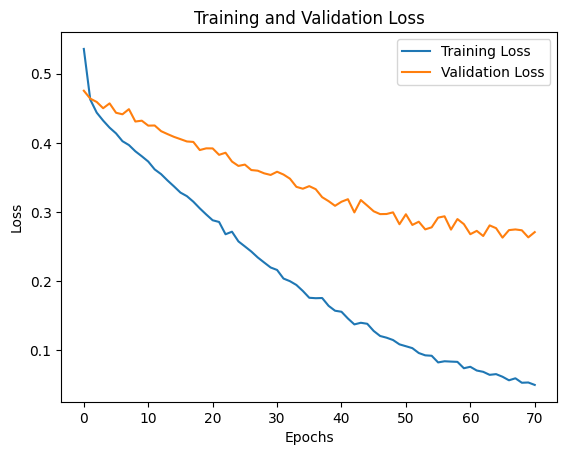

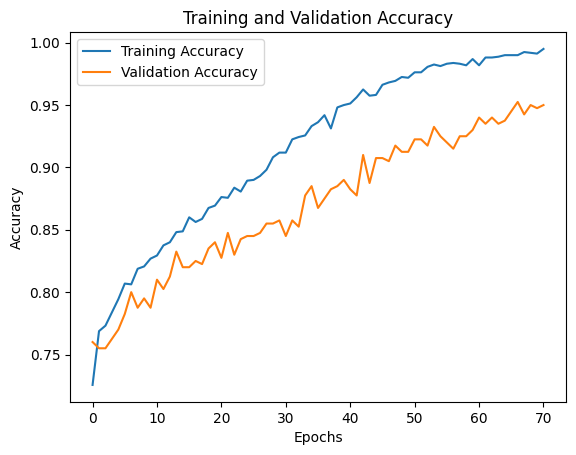

In [57]:
#Plot loss and history for DNN epochs
plot_loss(history)
plot_accuracy(history)


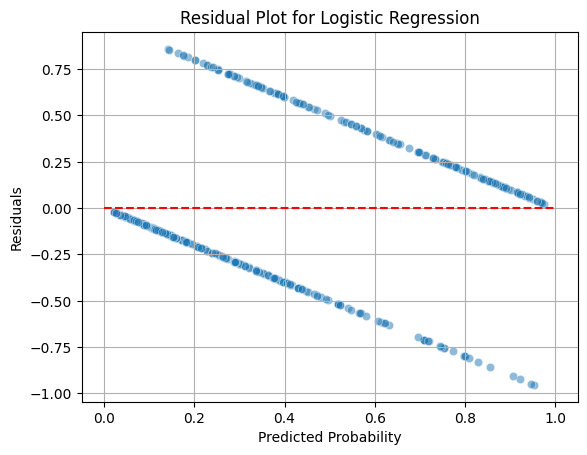

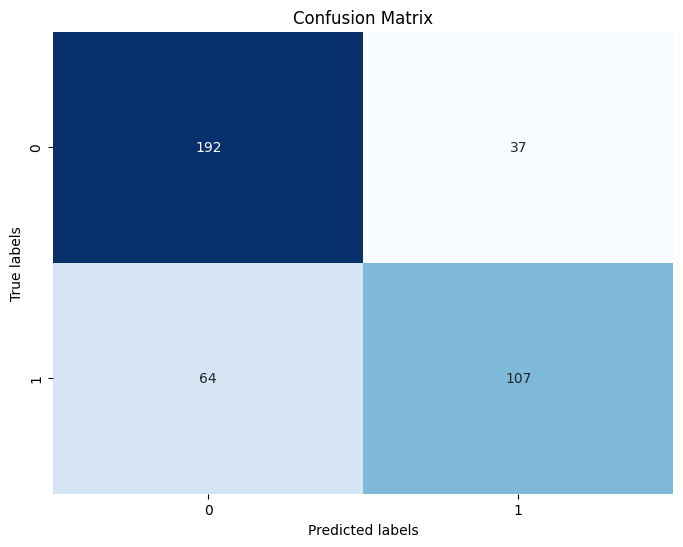

In [66]:
#Residual Plot for Logi
plot_logistic_regression_residuals(logistic_model, X_test, y_test)
plot_confusion_matrix(logistic_model, X_test, y_test)

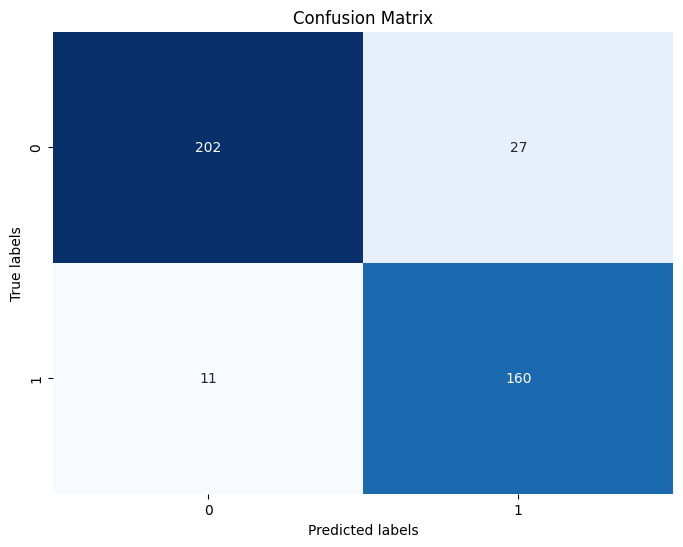

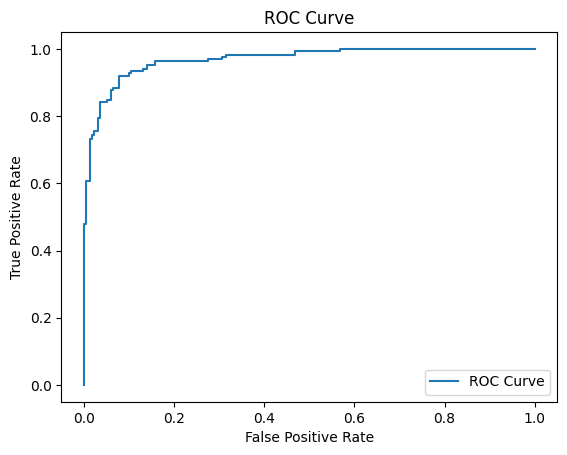

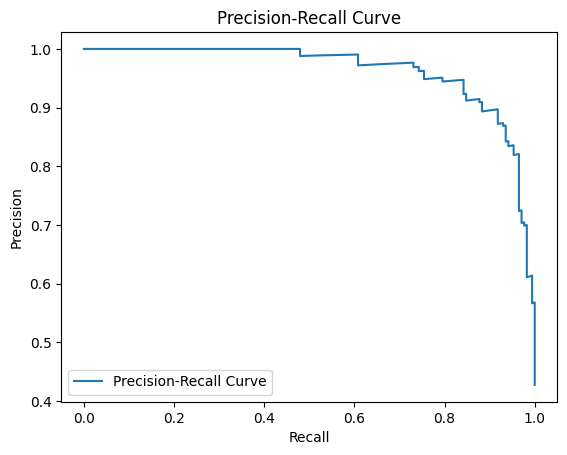

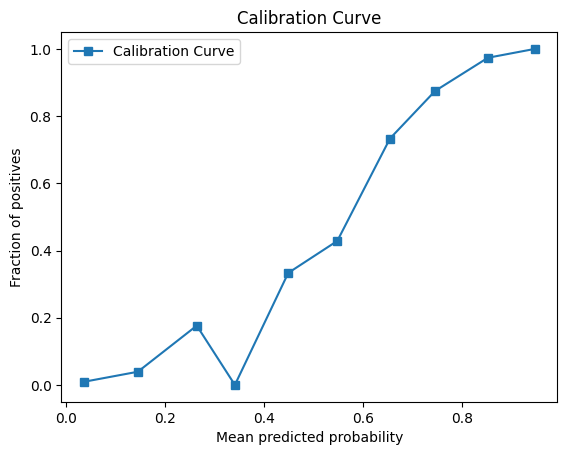

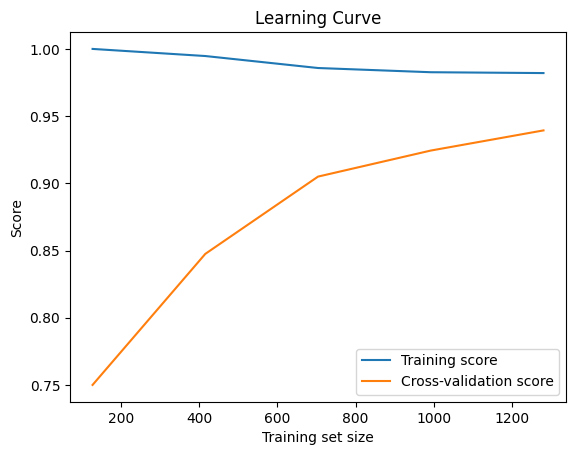

In [59]:

#Visualization for Random Forest Model
plot_confusion_matrix(rf_model, X_test, y_test)
plot_roc_curve(rf_model, X_test, y_test)
plot_precision_recall_curve(rf_model, X_test, y_test)
plot_calibration_curve(rf_model, X_test, y_test)
plot_learning_curve(rf_model, X_train, y_train)

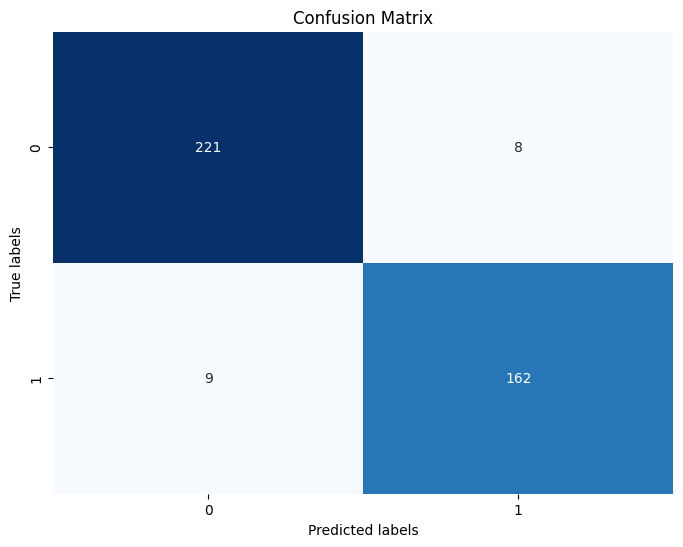

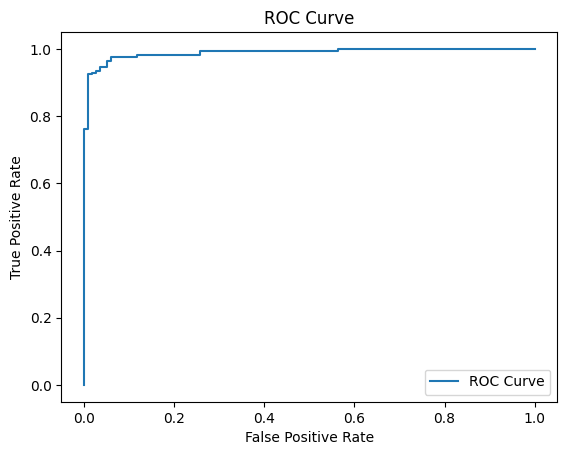

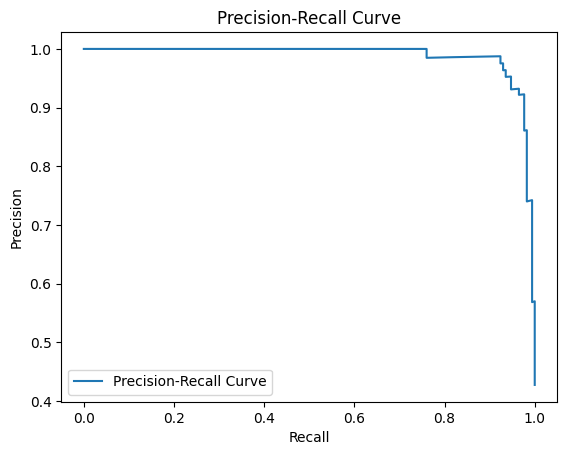

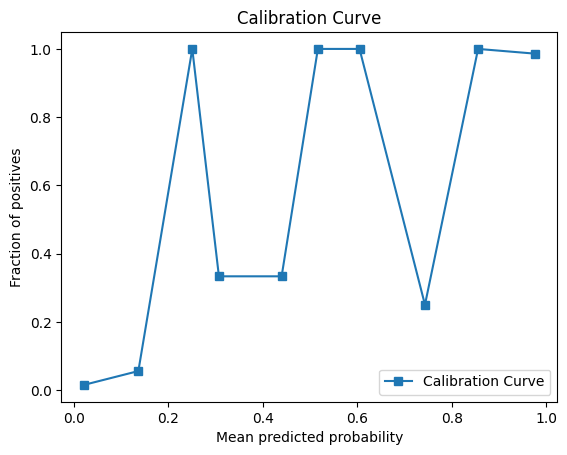

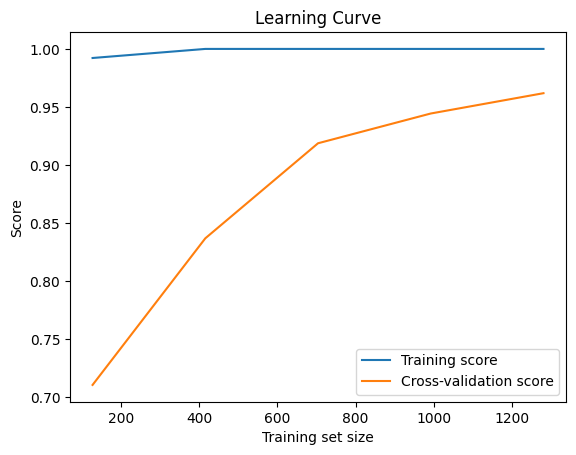

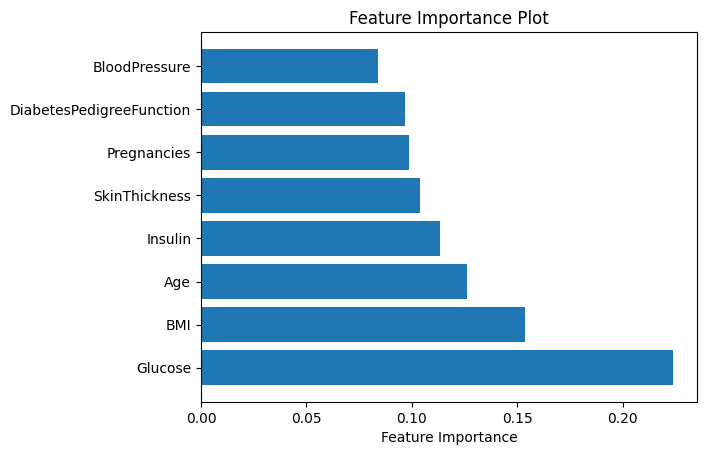

In [60]:

#Visualization for XGB Model
plot_confusion_matrix(xgb_model, X_test, y_test)
plot_roc_curve(xgb_model, X_test, y_test)
plot_precision_recall_curve(xgb_model, X_test, y_test)
plot_calibration_curve(xgb_model, X_test, y_test)
plot_learning_curve(xgb_model, X_train, y_train)
plot_feature_importance(xgb_model, feature_names)


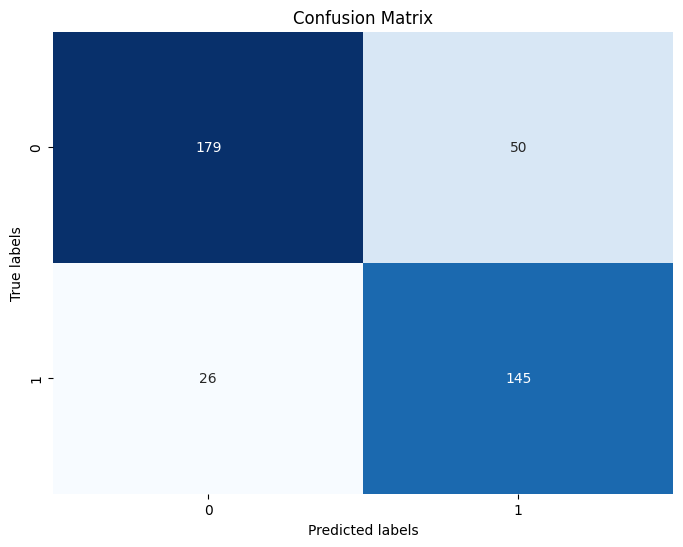

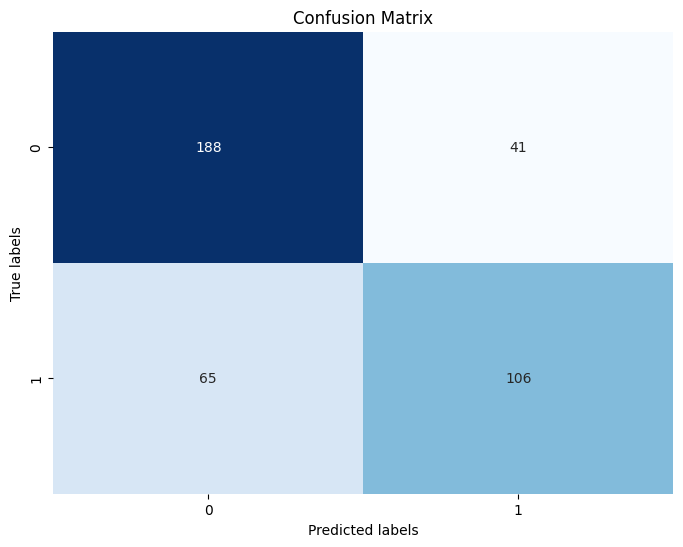

In [67]:
plot_confusion_matrix(svm_model, X_test, y_test)
plot_confusion_matrix(gnb_model, X_test, y_test)

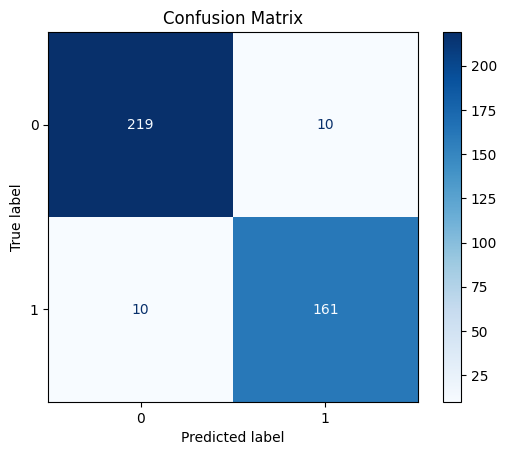

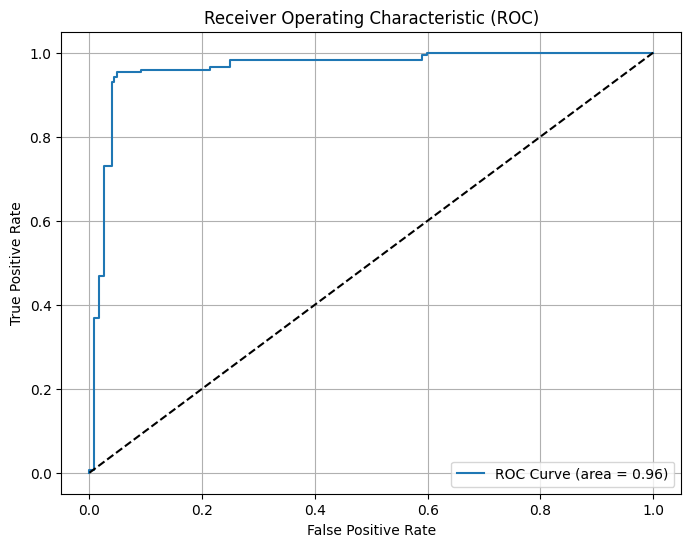

In [61]:
#Visualization for DNN Model
# Compute confusion matrix
from sklearn.metrics import  ConfusionMatrixDisplay
cm = confusion_matrix(y_test, dnn_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, dnn_pred_prob)
roc_auc = roc_auc_score(y_test, dnn_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

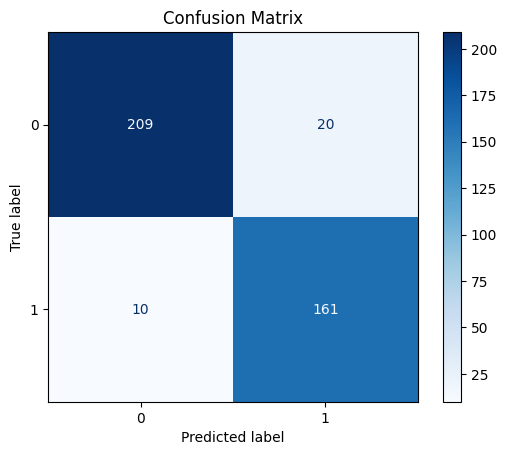

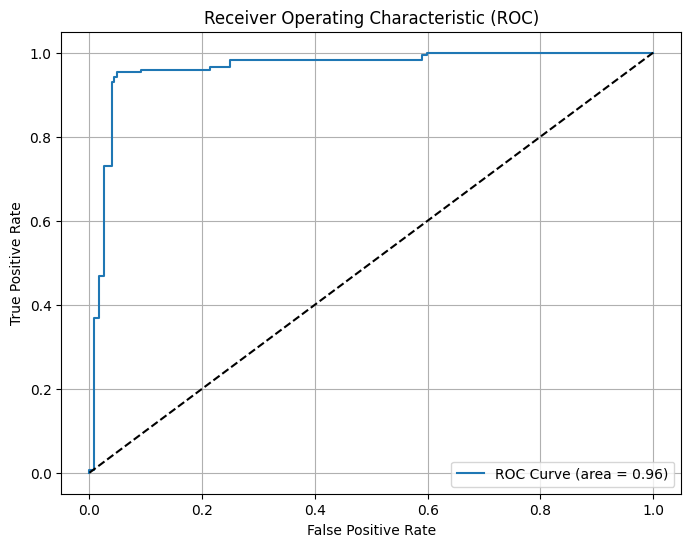

In [62]:
#Visualization for FNN Model
# Compute confusion matrix
from sklearn.metrics import  ConfusionMatrixDisplay
cm = confusion_matrix(y_test, fnn_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, dnn_pred_prob)
roc_auc = roc_auc_score(y_test, dnn_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [63]:
from sklearn.metrics import precision_score
def calculate_model_precision(y_true, model_predictions, model_name):
  
    precision = precision_score(y_true, model_predictions)
    print(f"{model_name} Precision: {precision:.4f}")

# Example usage for different models
calculate_model_precision(y_test, rf_pred, "RF Model")
calculate_model_precision(y_test, xgb_pred, "XGBoost Model")
# calculate_model_precision(y_test, logistic_pred, "Logistic Regression Model")
calculate_model_precision(y_test, dnn_pred, "DNN Model")
calculate_model_precision(y_test, fnn_pred, "FNN Model")
calculate_model_precision(y_test, gnb_pred, "Navie Bayes")
#calculate_model_precision(y_test, svm_pred, "SVM")

RF Model Precision: 0.8556
XGBoost Model Precision: 0.9529
DNN Model Precision: 0.9415
FNN Model Precision: 0.8895
Navie Bayes Precision: 0.7211


In [64]:
import warnings
warnings.filterwarnings('ignore')
def preprocess_new_data_array(new_data_array, mean_values, scaler):
    # Convert the array to a DataFrame with appropriate column names
    column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
    new_data_df = pd.DataFrame(new_data_array, columns=column_names)

    # Replace 0 values with the mean of the column
    new_data_df[column_to_modify] = new_data_df[column_to_modify].replace(0, mean_values)

    # Feature Engineering: log transformation of 'DiabetesPedigreeFunction'
    new_data_df['DiabetesPedigreeFunction'] = np.log1p(new_data_df['DiabetesPedigreeFunction'])

    # Select only numeric features
    X_new = new_data_df.select_dtypes(include=["int64", "float64"])

    # Scale the features
    X_new_scaled = scaler.transform(X_new)

    return X_new_scaled

# Example new data sample with 8 inputs
new_sample = np.array([[2,90,85,1.2,200,35.8,1.583,42]])
0.845,2
# Preprocess the new sample array
X_new_scaled = preprocess_new_data_array(new_sample, mean_values, scaler)

# Make predictions
predictions = xgb_model.predict(X_new_scaled)

print("Predictions:", predictions)

Predictions: [0]


In [65]:
import pickle
with open('model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)